In [2]:
import heapq
import random
import scipy.stats as sts
from operator import attrgetter
import numpy as np

In [3]:
# taken from the class resources
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.

    Attributes
    ----------
    timestamp : float
        The time at which the event should run.
    function : function
        The function to call when running the event.
    args : tuple
        The positional arguments to pass to the function.
    kwargs : dict
        The keyword arguments to pass to the function.


    '''

    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def run(self, schedule):
        self.function(schedule, *self.args, **self.kwargs)
        

class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.

    The `now` attribute contains the time at which the last event was run.

    Attributes
    ----------
    now : float
        The time at which the last event was run.
    priority_queue : list
        The priority queue of events. Each event is an instance of the Event

    '''

    def __init__(self):
        self.now = 0
        self.priority_queue = []

        # For empirical analysis comparison
        self.queue_lengths = []
        self.customers_in_system = []
        self.max_queue_length = 0

    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the priority queue at a specific time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))

    def add_event_after(self, interval, function, *args, **kwargs):
        self.add_event_at(self.now + interval, function, *args, **kwargs)

    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Run the next event in the priority queue.
        event = heapq.heappop(self.priority_queue)        
        self.now = event.timestamp
        event.run(self)

    def __repr__(self):
        return (
                f'Schedule() at time {self.now}min ' +
                f'with {len(self.priority_queue)} events in the queue')

    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')



In [4]:
class Customer:
    """ 
    Customer class to store the metrics of each customer.

    Attributes: 
        arrival_time (float): time at which the customer arrives at the queue
        wait_time (float): time spent waiting in the queue
        start_service_time (float): time at which the customer starts being served
        finish_service_time (float): time at which the customer finishes being served
        m_arrival_time (float): time at which the customer arrives at the manager's queue
        manager_wait_time (float): time spent waiting for the manager
        m_start_service_time (float): time at which the customer starts being served by the manager
        m_finish_service_time (float): time at which the customer finishes being served by the manager
    """

    def __init__(self, arrival_time, wait_time, start_service_time, finish_service_time, m_arrival_time, manager_wait_time, m_start_service_time, m_finish_service_time):
        self.arrival_time = arrival_time
        self.wait_time = wait_time
        self.start_service_time = start_service_time
        self.finish_service_time = finish_service_time
        self.m_arrival_time = m_arrival_time
        self.manager_wait_time = manager_wait_time
        self.m_start_service_time = m_start_service_time
        self.m_finish_service_time = m_finish_service_time 

    def get_metrics(self):
        # Get overall wait time and response time for the customer
        self.total_wait_time = self.wait_time
        
        if self.manager_wait_time != 0:
            self.total_wait_time += self.manager_wait_time
        
        self.response_time = self.finish_service_time - self.arrival_time

        if self.m_finish_service_time != 0:
            self.response_time += (self.m_finish_service_time - self.m_arrival_time)



class Queue_MG1:
    """
    Queue class to store the metrics of each queue in the grocery store.

    Attributes:
        service_distribution (str): distribution of the service time
        people_in_queue (int): number of people in the queue, waiting
        people_being_served (int): number of people being served who originated from that queue
        queue_number (int): number of the queue (to keep track of minimum queue)
        run_until (float): time at which the simulation ends
        current_customers (list): list of customers currently in the queue
        serving_customers (list): list of customers currently being served
        served_customers (list): list of customers who have been served by this queue
        max_queue_length (int): maximum length of the given queue


    """

    def __init__(self, service_distribution, queue_number, manager, run_until):

        self.service_distribution = service_distribution
        self.people_in_queue = 0
        self.people_being_served = 0

        self.queue_number = queue_number
        self.run_until = run_until

        # variables to keep track of the time spent in the queue (future metrics)

        self.current_customers = []
        self.serving_customers = []
        self.served_customers = []

        self.max_queue_length = 0

        

    def add_customer(self, schedule, manager):
        # Add the customer to the queue
        
        if self.run_until >= schedule.now:
            customer = Customer(schedule.now, 0, 0, 0, 0, 0, 0, 0)
            self.current_customers.append(customer)
            self.people_in_queue += 1
            

            if self.people_being_served < 1:
                # This customer can be served immediately
                schedule.add_event_after(0, self.start_serving_customer, manager)



    def start_serving_customer(self, schedule, manager):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        # choose the customers with the earliest arrival time
        if self.current_customers != []:
            self.curr_customer = min(self.current_customers, key=attrgetter("arrival_time"))

            # update the time they got served
            self.curr_customer.start_service_time = schedule.now
            # update the wait_time of the customer
            self.curr_customer.wait_time = self.curr_customer.start_service_time - self.curr_customer.arrival_time

            # move the customer from the waiting to the serving list
            self.current_customers.remove(self.curr_customer)
            self.serving_customers.append(self.curr_customer)


            schedule.add_event_after(
                self.service_distribution.rvs(),
                self.finish_serving_customer, manager)

    def finish_serving_customer(self, schedule, manager):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.serving_customers != []:
            # choose the customer with the earliest start service time
            self.curr_customer = min(self.serving_customers, key=attrgetter("start_service_time"))
            # update when they finished getting served
            self.curr_customer.finish_service_time = schedule.now
            # remove the customer from the queue
            self.serving_customers.remove(self.curr_customer)
            # add the customer to the served list
            self.served_customers.append(self.curr_customer)
            

            if self.people_in_queue > 0:
                # There are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer, manager)

            # 5% chance that the person who just got served will join the manager queue
            if random.random() < 0.05:

                # add the customer to the manager queue
                self.send_customer_to_manager(schedule, manager, self.curr_customer)
                


    
    def send_customer_to_manager(self, schedule, manager, customer):
        # with a 5% chance likelihood, the person who just got served will join the Manager queue
        manager.add_customer(schedule, customer)

    



class Manager():
    """
    Manager queue class.

    Attributes:
        service_distribution: distribution of service times
        people_in_queue: number of people in the manager queue
        people_being_served: number of people being served in the manager queue
        start_serving: time at which the manager starts serving a customer
        finish_serving: time at which the manager finishes serving a customer
        current_customers (list): list of customers currently in the manager queue
        serving_customers (list): list of customers currently being served by the manager
        served_customers (list): list of customers who have been served by the manager

    """
    def __init__(self, service_distribution):
        self.service_distribution = service_distribution
        self.people_in_queue = 0
        self.people_being_served = 0
        
        self.start_serving = 0
        self.finish_serving = 0

        self.m_current_customers = []
        self.m_serving_customers = []
        self.m_served_customers = []


    def add_customer(self, schedule, customer):

        # Add the customer to the queue
        self.m_current_customers.append(customer)
        # print the values of all of the attributes of the customer
        # customer manager arrival time is now
        customer.m_arrival_time = schedule.now
        
        self.people_in_queue += 1

        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # choose the customer who arrived first to the manager queue
        self.people_in_queue -= 1
        self.people_being_served += 1

        if self.m_current_customers != []:
            self.curr_customer = min(self.m_current_customers, key=attrgetter("m_arrival_time"))
            
            
            # update the time the customer started being served
            self.curr_customer.m_start_service_time = schedule.now

            # update the wait time of the customer
            self.curr_customer.m_wait_time = self.curr_customer.m_start_service_time - self.curr_customer.m_arrival_time


            # remove the customer from the queue to the serving list
            self.m_current_customers.remove(self.curr_customer)
            self.m_serving_customers.append(self.curr_customer)
            

            schedule.add_event_after(self.service_distribution.rvs(), 
            self.finish_serving_customer)

            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the Manager
        self.people_being_served -= 1

        if self.m_serving_customers != []:

            # choose the customer with the earliest start service time
            self.curr_customer = min(self.m_serving_customers, key=attrgetter("m_start_service_time"))
            # update when they finished getting served
            self.curr_customer.m_finish_service_time = schedule.now
            # remove the customer from the queue
            self.m_serving_customers.remove(self.curr_customer)
            # add the customer to the served list
            self.m_served_customers.append(self.curr_customer)


            if self.people_in_queue > 0:
                # There are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer)
    


class GroceryStore_MG1_c:
    """
    Grocery Store class which contains c queues and a manager queue.

    Attributes:
        arrival_distribution: distribution of arrival times
        run_until: time at which the simulation ends
        manager: manager queue
        queues (list): list of queues

    """

    def __init__(self, arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until):

        self.arrival_distribution = arrival_distribution
        self.run_until = run_until

        self.manager = Manager(manager_serv_distribution)

        self.queues = {}
        for i in range(num_queues):
            self.queues[i] = Queue_MG1(service_distribution, i, self.manager, self.run_until)

    def add_customer(self, schedule):

        # Chooses the longest queue for the metrics
        longest_queue = max(self.queues.values(), key=attrgetter("people_in_queue")).people_in_queue 
        schedule.max_queue_length = max(schedule.max_queue_length, longest_queue)


        # only adds customers until 8 PM
        if self.run_until >= schedule.now:
            # find the queue with the smallest number of people
            self.min_queue = min(self.queues.values(), key=attrgetter("people_in_queue"))

            # Add this customer to that queue
            self.min_queue.add_customer(schedule, self.manager)
            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)



    def run(self, schedule):
        # Schedule the first customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(), 
            self.add_customer)

    def get_people_in_system(self):
            # go through each queue and add all people waiting and served
            self.people_in_system = 0
            for q in self.queues.values():
                self.people_in_system += q.people_in_queue
                self.people_in_system += q.people_being_served
            # also add people in the manager queue or being served by manager
            self.people_in_system += self.manager.people_in_queue
            self.people_in_system += self.manager.people_being_served
            return self.people_in_system

    def get_metrics(self, schedule):
        # get the metrics for each queue
        # get all the customers from all the queues
        self.avg_wait_time = 0
        self.avg_response_time = 0
        self.num_total_customers = 0


        for q in self.queues.values():
            for c in q.served_customers:
                self.num_total_customers += 1
                c.get_metrics()
                self.avg_wait_time += c.total_wait_time
                self.avg_response_time += c.response_time
        
        self.avg_wait_time /= self.num_total_customers
        self.avg_response_time /= self.num_total_customers
        self.max_queue_length = schedule.max_queue_length


    



def run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until):
    
    schedule = Schedule()
    grocery_store = GroceryStore_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, num_queues, run_until)
    grocery_store.run(schedule)
    
    times = []
    population = []
    # allows events to run while priority queue is not empty
    while schedule.priority_queue:
        # get minute from schedule.now

        if int(schedule.now) % 2 == 0:
            times.append(schedule.now)
            # for all queues get number of people in system
            people_in_system = grocery_store.get_people_in_system()
            population.append(people_in_system)

        schedule.run_next_event()
    grocery_store.max_customers_in_system = max(population)
    
    grocery_store.get_metrics(schedule)
    grocery_store.population = population
    grocery_store.times = times

    print(f'Finished running simulation for {run_until} minutes for {num_queues} queues')
    return grocery_store


In [5]:
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=np.sqrt(1))
manager_serv_distribution = sts.norm(loc=5, scale=np.sqrt(2))
number_queues = 5


duration = (20 - 9)*60
print(duration)

grocery_store = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, number_queues, duration)

660
Finished running simulation for 660 minutes for 5 queues


In [6]:
import scipy.stats as sts

arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=np.sqrt(1))
manager_serv_distribution = sts.norm(loc=5, scale=np.sqrt(2))


duration = (20 - 9)*60
print(duration)


trials = 100


wait_times = [ [] for _ in range(10) ]
response_times = [ [] for _ in range(10) ]
max_customers_in_system = [ [] for _ in range(10) ]
max_queue_length =  [ [] for _ in range(10) ]

w_means = []
w_sems = []
w_CIs = []

r_means = []
r_sems = []
r_CIs = []

mcs_means = []
mcs_sems = []
mcs_CIs = []

mql_means = []
mql_sems = []
mql_CIs = []


for n in range(1, 11):

    for trial in range(trials):
        gc = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, n, duration)
        
        wait_times[n-1].append(gc.avg_wait_time)
        response_times[n-1].append(gc.avg_response_time)
        max_customers_in_system[n-1].append(gc.max_customers_in_system)
        max_queue_length[n-1].append(gc.max_queue_length)
    
    # the index in the respective lists would correspond to the number of queues
    wm = np.mean(wait_times[n-1])
    w_means.append(wm)

    wsem = sts.sem(wait_times[n-1])
    w_sems.append(wsem)

    w_lower_bound = wm - 1.96*wsem
    w_upper_bound = wm + 1.96*wsem
    w_CIs.append((w_lower_bound, w_upper_bound))


    rm = np.mean(response_times[n-1])
    r_means.append(rm)

    rsem = sts.sem(response_times[n-1])
    r_sems.append(rsem)

    r_lower_bound = rm - 1.96*rsem
    r_upper_bound = rm + 1.96*rsem
    r_CIs.append((r_lower_bound, r_upper_bound))

    mcsm = np.mean(max_customers_in_system[n-1])
    mcs_means.append(mcsm)

    mcssem = sts.sem(max_customers_in_system[n-1])
    mcs_sems.append(mcssem)

    mcs_lower_bound = mcsm - 1.96*mcssem
    mcs_upper_bound = mcsm + 1.96*mcssem
    mcs_CIs.append((mcs_lower_bound, mcs_upper_bound))


    mqlm = np.mean(max_queue_length[n-1])
    mql_means.append(mqlm)

    mqlsem = sts.sem(max_queue_length[n-1])
    mql_sems.append(mqlsem)

    mql_lower_bound = mqlm - 1.96*mqlsem
    mql_upper_bound = mqlm + 1.96*mqlsem
    mql_CIs.append((mql_lower_bound, mql_upper_bound))




660
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation for 660 minutes for 1 queues
Finished running simulation

In [7]:
# make a table with means, standard errors, confidence intervals
import pandas as pd
# index is number of queues

num_qs = np.linspace(1, 10, 10)

d = {'Number of quues': num_qs, 'Wait time means' : w_means, 'Wait time standard errors' : w_sems, 'Wait time confidence intervals' : w_CIs, 'Response time means' : r_means, 'Response time standard errors' : r_sems, 'Response time confidence intervals' : r_CIs, 'Max customers in system means' : mcs_means, 'Max customers in system standard errors' : mcs_sems, 'Max customers in system confidence intervals' : mcs_CIs, 'Max queue length means' : mql_means, 'Max queue length standard errors' : mql_sems, 'Max queue length confidence intervals' : mql_CIs}
df = pd.DataFrame(data=d)
df

,Number of quues,Wait time means,Wait time standard errors,Wait time confidence intervals,Response time means,Response time standard errors,Response time confidence intervals,Max customers in system means,Max customers in system standard errors,Max customers in system confidence intervals,Max queue length means,Max queue length standard errors,Max queue length confidence intervals
0,1.0,656.032513,4.373554,"(647.4603467433623, 664.6046795529384)",659.285907,4.374440,"(650.7120052940056, 667.8598094861782)",438.92,2.936557,"(433.1643473847114, 444.67565261528864)",437.56,2.934308,"(431.80875557933217, 443.31124442066783)"
1,2.0,166.934230,2.110238,"(162.79816401649668, 171.0702966585025)",170.215180,2.110449,"(166.0787002569081, 174.35165927595605)",224.48,2.736601,"(219.1162617444227, 229.84373825557728)",111.35,1.368135,"(108.66845572157166, 114.03154427842833)"
2,3.0,14.411006,0.681678,"(13.07491743834039, 15.74709470127077)",17.696506,0.681339,"(16.361080739148836, 19.03193075049506)",36.75,1.167089,"(34.46250621019775, 39.03749378980225)",11.33,0.391076,"(10.563491124538263, 12.096508875461737)"
3,4.0,2.202363,0.025061,"(2.1532444211476918, 2.251482120438113)",5.489230,0.026585,"(5.437124034918359, 5.5413359680712055)",14.97,0.227172,"(14.52474308222299, 15.415256917777011)",3.01,0.062757,"(2.8869971733920905, 3.133002826607909)"
4,5.0,1.695572,0.007873,"(1.68014066136932, 1.7110030906969276)",5.002908,0.012264,"(4.978870446574103, 5.026946481672756)",12.92,0.154187,"(12.617792803700922, 13.222207196299077)",1.97,0.036111,"(1.8992214607655569, 2.0407785392344433)"
5,6.0,1.637468,0.004661,"(1.628332881775971, 1.646604063709051)",4.930715,0.009729,"(4.911646725448593, 4.949783208639255)",12.84,0.136122,"(12.573200202928916, 13.106799797071083)",1.38,0.048783,"(1.2843849806819454, 1.4756150193180544)"
6,7.0,1.630254,0.005055,"(1.6203459177530073, 1.640161722756217)",4.913321,0.011241,"(4.891289075595194, 4.935352733464076)",12.88,0.128927,"(12.627302693150702, 13.1326973068493)",1.05,0.021904,"(1.0070675889427123, 1.0929324110572878)"
7,8.0,1.625226,0.003997,"(1.6173908891907574, 1.6330607606982745)",4.926374,0.009687,"(4.907388008450897, 4.945359883688178)",12.69,0.129252,"(12.436666223285874, 12.943333776714125)",1.01,0.010000,"(0.9904000000000001, 1.0296)"
8,9.0,1.628503,0.004280,"(1.6201135911615534, 1.636891907877608)",4.919306,0.010869,"(4.898003207596674, 4.940609759166837)",12.83,0.131083,"(12.573076756342846, 13.086923243657154)",1.00,0.000000,"(1.0, 1.0)"
9,10.0,1.629707,0.004897,"(1.6201095538468553, 1.6393047323256655)",4.926817,0.010662,"(4.905918789231464, 4.947714852934109)",12.52,0.120168,"(12.284470264803748, 12.755529735196252)",1.00,0.000000,"(1.0, 1.0)"


/var/folders/4t/ddfqyc995sl4jwpdczms8knr0000gn/T/ipykernel_47720/1990816462.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(num_qs, w_means, w_sems, fmt='o', color='black', marker='o', markersize=3, capsize=5, linestyle='--', linewidth=1)


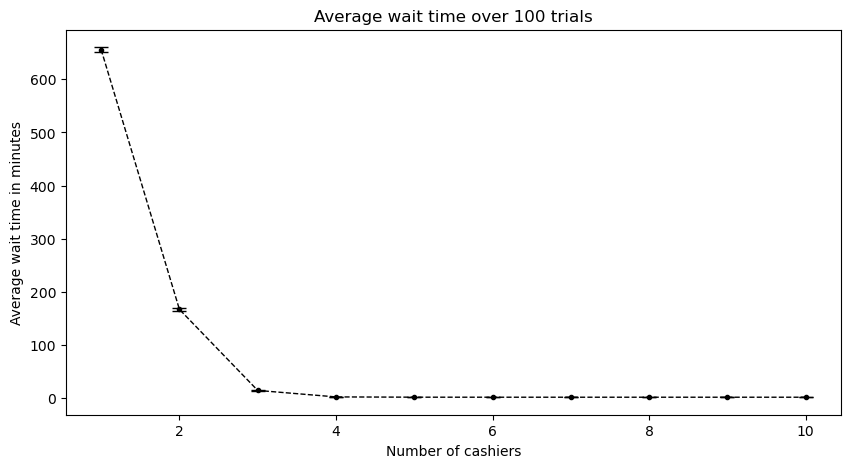

/var/folders/4t/ddfqyc995sl4jwpdczms8knr0000gn/T/ipykernel_47720/1990816462.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(num_qs, r_means, r_sems, fmt='o', color='black', marker='o', markersize=3,  capsize=5, linestyle='--', linewidth=1)


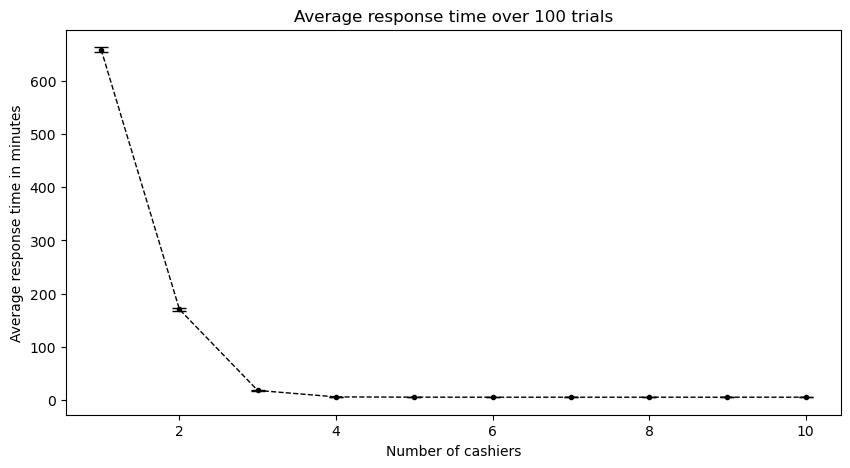

In [8]:
import matplotlib.pyplot as plt


# make size of plot bigger
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.errorbar(num_qs, w_means, w_sems, fmt='o', color='black', marker='o', markersize=3, capsize=5, linestyle='--', linewidth=1)
plt.title(f'Average wait time over {trials} trials')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average wait time in minutes')
plt.show()


plt.errorbar(num_qs, r_means, r_sems, fmt='o', color='black', marker='o', markersize=3,  capsize=5, linestyle='--', linewidth=1)
plt.title(f'Average response time over {trials} trials')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average response time in minutes')
plt.show()


plt.errorbar(num_qs, mcs_means, mcs_sems, fmt='o', color='black', marker='o',  markersize=3, capsize=5, linestyle='--', linewidth=1)
plt.title(f'Average max. number of customers in the system over {trials} trials')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average maximum number of customers')
plt.show()

plt.errorbar(num_qs, mql_means, mql_sems, fmt='o', color='black', marker='o', markersize=3,  capsize=5, linestyle='--', linewidth=1)
plt.title(f'Average maximum queue length over {trials} trials')
plt.xlabel('Number of cashiers')
plt.ylabel(f'Average maximum wait time in minutes')
plt.show()


Finished running simulation for 100 minutes for 1 queues
Finished running simulation for 100 minutes for 3 queues
Finished running simulation for 100 minutes for 10 queues
Finished running simulation for 100 minutes for 1 queues
Finished running simulation for 100 minutes for 3 queues
Finished running simulation for 100 minutes for 10 queues
Finished running simulation for 100 minutes for 1 queues
Finished running simulation for 100 minutes for 3 queues
Finished running simulation for 100 minutes for 10 queues
Finished running simulation for 100 minutes for 1 queues
Finished running simulation for 100 minutes for 3 queues
Finished running simulation for 100 minutes for 10 queues


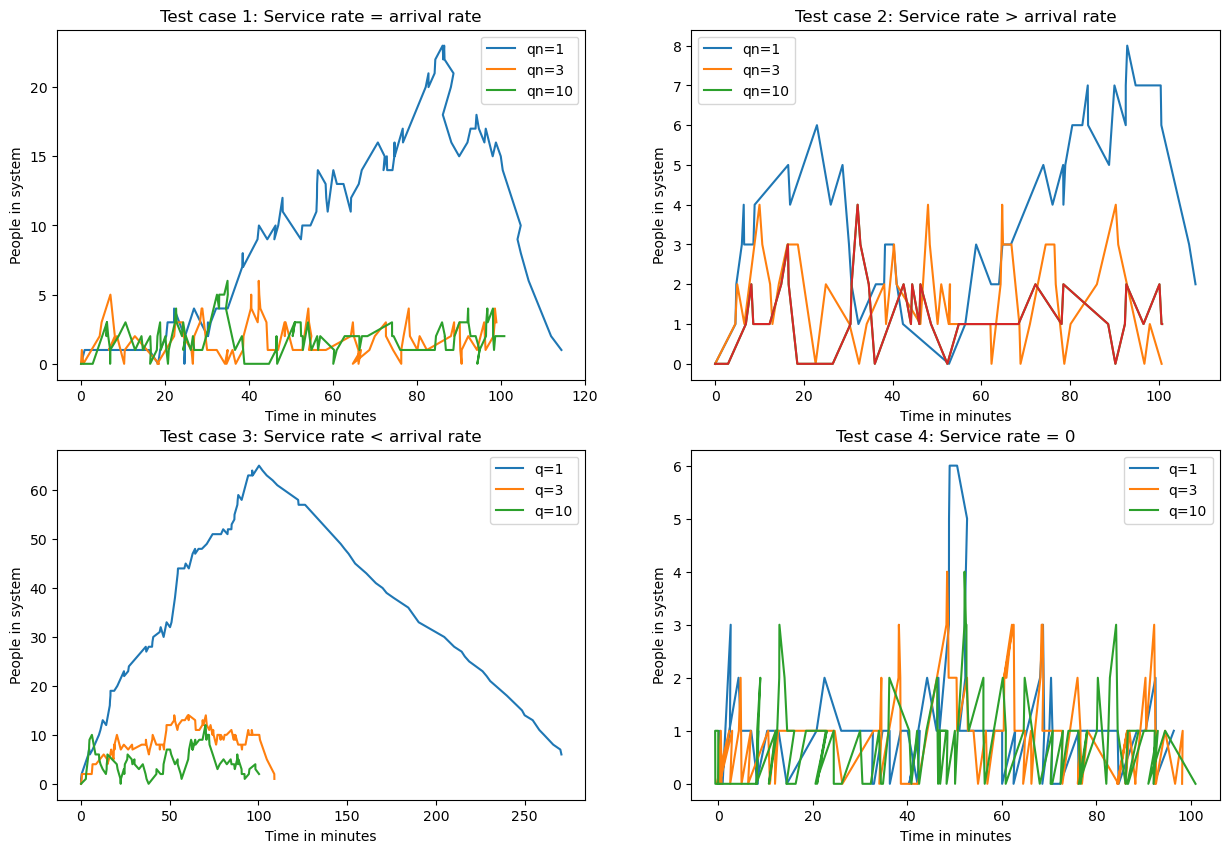

In [ ]:
# Test cases
# six test cases we defined
# shorter run until
# plotting schedule vs customers in system

# plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))


# test case 1: service rate = arrival rate
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=1, scale=np.sqrt(1))
manager_serv_distribution = sts.expon(scale=1)
duration = 100

for qn in [1, 3, 10]:
    gc1 = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, qn, duration)
    axs[0,0].plot(gc1.times, gc1.population, label=f'qn={qn}')
axs[0,0].set_title('Test case 1: Service rate = arrival rate')
axs[0,0].set_xlabel('Time in minutes')
axs[0,0].set_ylabel('People in system')
axs[0,0].legend()


# test case 2: service rate > arrival rate
arrival_distribution = sts.expon(scale=2)
service_distribution = sts.norm(loc=2, scale=np.sqrt(1))
manager_serv_distribution = sts.expon(scale=1)
duration = 100

for qn in [1, 3, 10]:
    gc2 = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, qn, duration)
    axs[0,1].plot(gc2.times, gc2.population, label=f'qn={qn}')
axs[0,1].plot(gc2.times, gc2.population)
axs[0,1].set_title('Test case 2: Service rate > arrival rate')
axs[0,1].set_xlabel('Time in minutes')
axs[0,1].set_ylabel('People in system')
axs[0,1].legend()


# test case 3: service rate < arrival rate
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=np.sqrt(1))
manager_serv_distribution = sts.expon(scale=1)
duration = 100

for qn in [1, 3, 10]:
    gc3 = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, qn, duration)
    axs[1,0].plot(gc3.times, gc3.population, label=f'q={qn}')
axs[1,0].set_title('Test case 3: Service rate < arrival rate')
axs[1,0].set_xlabel('Time in minutes')
axs[1,0].set_ylabel('People in system')
axs[1,0].legend()

# test case 4: service rate = 0
arrival_distribution = sts.expon(scale=1.2)
service_distribution = sts.norm(loc=0, scale=np.sqrt(1))
manager_serv_distribution = sts.expon(scale=1)
duration = 100

for qn in [1, 3, 10]:
    gc4 = run_simulation_MG1_c(arrival_distribution, service_distribution, manager_serv_distribution, qn, duration)
    axs[1,1].plot(gc4.times, gc4.population, label=f'q={qn}')
axs[1,1].set_title('Test case 4: Service rate = 0')
axs[1,1].set_xlabel('Time in minutes')
axs[1,1].set_ylabel('People in system')
axs[1,1].legend()

plt.show()